# Importo librerias

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.optimize import curve_fit

# Cargado de archivos

In [47]:
c = 3e8 #m/s
X, Y, V, nu = [], [], [], [] # --> Cada elemento de la lista corresponde a los datos de una longitud de onda

folder = 'Mediciones/Barrido voltaje'
fname = os.listdir(folder + '/')
for file in fname[:-2]:
    root = folder + '/' + file
    if file[:7] == 'barrido':
        medXYV = np.genfromtxt(root, delimiter = ',')
        N = len(medXYV)
        Xi, Yi, Vi = np.zeros(N - 1), np.zeros(N - 1), np.zeros(N - 1)
        for i, row in enumerate(medXYV[1:]):
            Xi[i], Yi[i], Vi[i] = row[0], row[1], row[2]
        X.append(Xi), Y.append(Yi), V.append(Vi)
        lamb = float(file[16:-6])*1e-9 #m
        nu.append(2 * np.pi * c / lamb)

R = [np.sqrt(x**2 + y**2) for x, y in zip(X, Y)]

# Cálculo de $I$ y $V_0$

In [48]:
#G = 10e6
G = 1
ep = -.3e-10
I = [np.sqrt( (x/G)**2 + (y/G)**2 ) for x, y in zip(X, Y)]

# Obtengo el V / I = 0
def V0min(x, v, epsilon = ep, p = -1):
    xc = x[(x <= 0) & (x >= epsilon)]
    vc = v[(x <= 0) & (x >= epsilon)]
    
    xc0, vc0, ind_vc0 = xc[p], vc[p], list(vc).index(vc[p])
    err_vc0 = np.mean([vc0 - v[ind_vc0 - 1], v[ind_vc0 + 1] - vc0])
    
    return xc0, vc0, err_vc0


# Gráficos de las mediciones

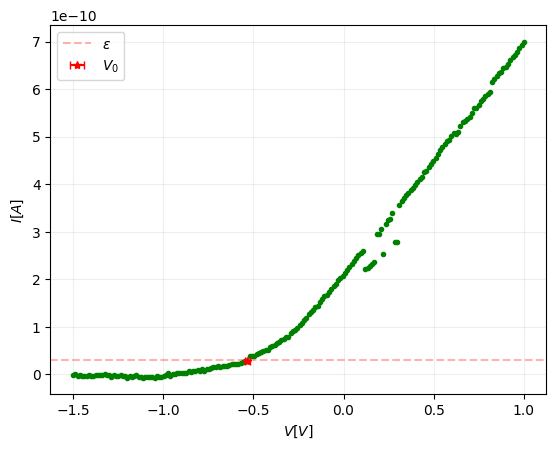

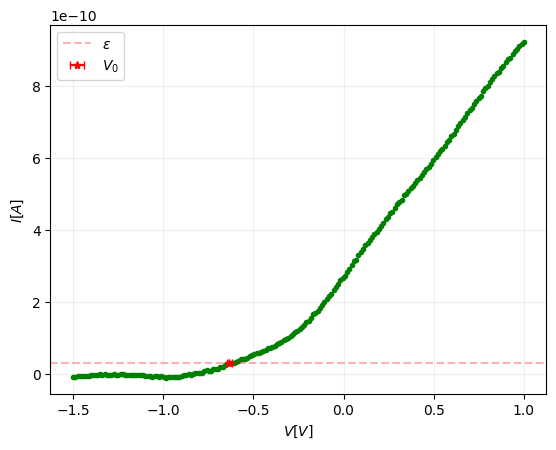

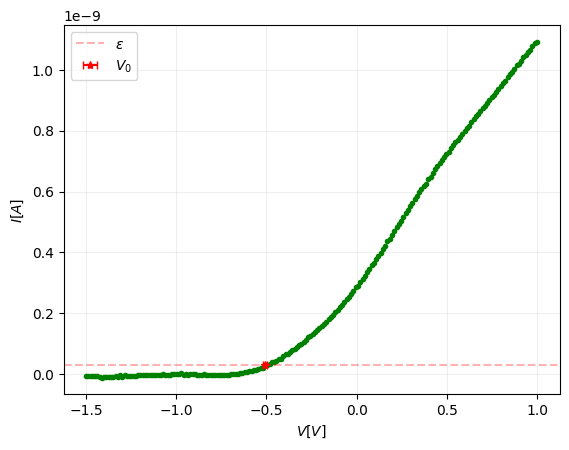

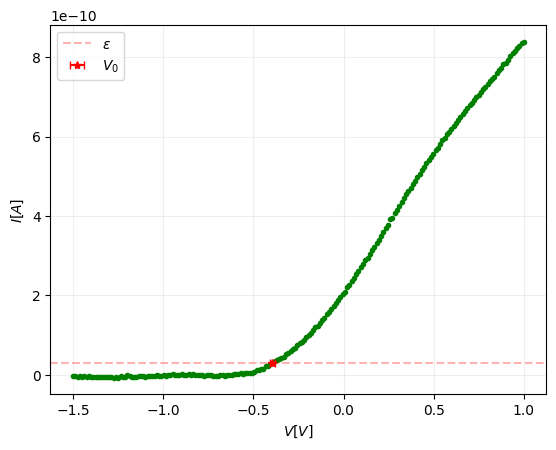

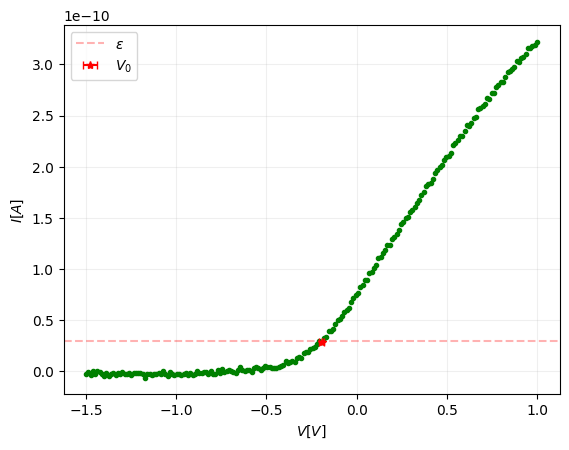

In [49]:
V0, err_V0 = np.zeros(len(X)), np.zeros(len(X))
for k in range(len(X)):
    Xc0k, V0[k], err_V0[k] = V0min(X[k], V[k])
    
    plt.figure()
    
    plt.plot(V[k], -X[k], '.', color = 'green')
    plt.errorbar(V0[k], -Xc0k, fmt = '*', xerr = err_V0[k], capsize = 3, 
                 linestyle = 'None', color = 'red', label = r'$V_0$') #-->Puntos de corriente nula
    
    plt.axhline(-ep, color = 'red', linestyle = '--', 
                alpha = 0.3, label = r'$\epsilon$') #--> Referencia tomada
    
    plt.xlabel(r'$V \left[V\right]$')
    plt.ylabel(r'$I \left[A\right]$')
    
    plt.grid(alpha = 0.2)
    plt.legend(loc = 'upper left')
    plt.show()

# Gráficos de ajuste

Función de ajuste:
$eV_0 = h \nu - \hat{\phi}$

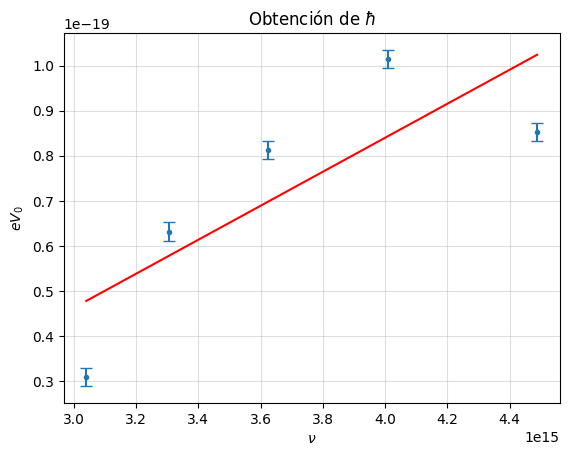

3.769728096924885e-35 1.6126518098138286e-35


In [52]:
# Defino e y paso a arrayos
elect = -1.60217663e-19 #C
V0, err_V0 = np.array(V0), np.array(err_V0)

# ------------Ajuste lineal------------
f = lambda x, a, c: a * x + c
popt, pcov = curve_fit(f, nu, elect*V0, sigma = np.abs(elect*err_V0), p0 = [6e-34, 0])
pcov = np.sqrt(np.diag(pcov))
h, err_h = popt[0], pcov[0]

# -----------Gráfico de ajustes----------
plt.figure()
plt.errorbar(nu, elect*V0, fmt = '.', yerr = np.abs(elect*err_V0), capsize = 4)
plt.plot(nu, f(np.array(nu), *popt), color = 'red')

plt.title(r'Obtención de $\hbar$')
plt.ylabel(r'$eV_0$')
plt.xlabel(r'$\nu$')

plt.grid(alpha = 0.4)
plt.show()

print(h, err_h)